In [2]:
print("Hello")

Hello


# Predicting movie genres based on its poster

In [24]:
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [25]:
#Utilities
import glob as gb
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
data_path = "/Volumes/TSARSHAH/Datasets/Movie-Genre/movie-genre-from-its-poster/MovieGenre.csv"

##### latin-1 encoding is used to avoid utf-8 decode error, invalid byte continuation errror

In [27]:
data = pd.read_csv(data_path, encoding='latin-1')
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [168]:
len(data)
row = data.loc[data['imdbId'] == 2544]
print(row)

       imdbId                         Imdb Link                        Title  \
27778    2544  http://www.imdb.com/title/tt2544  TrÌ_dgÌ´rdsmÌ_staren (1912)   

       IMDB Score  Genre                                             Poster  
27778         6.4  Drama  https://images-na.ssl-images-amazon.com/images...  


In [28]:
sample_images_path = "/Volumes/TSARSHAH/Datasets/Movie-Genre/movie-genre-from-its-poster/SampleMoviePosters"

In [29]:
image_glob = gb.glob(sample_images_path + "/" + "*.jpg")
img_dict = {}

In [30]:
def get_id(filename):
    
    index_s = filename.rfind("/") + 1
    index_f = filename.rfind('.jpg')
    
    return filename[index_s:index_f]

In [31]:
def get_image(id):
    return img_dict[id]

In [32]:
for po in image_glob:
    try:
        img_dict[get_id(po)] = scipy.misc.imread(po)
    except:
        pass

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


In [33]:
def display_poster(poster_id):
    
    title = data[data['imdbId'] == int(poster_id)]['Title'].values[0]
    genre = data[data['imdbId'] == int(poster_id)]['Genre'].values[0]
    
    plt.imshow(img_dict[poster_id])
    
    plt.title("{} \n {}".format(title, genre))

997


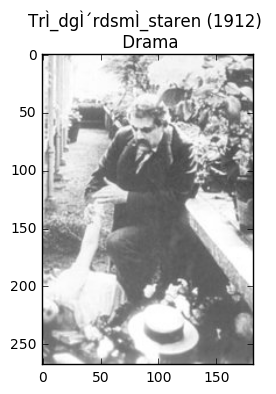

In [89]:
display_poster("2544")
print(len(img_dict))

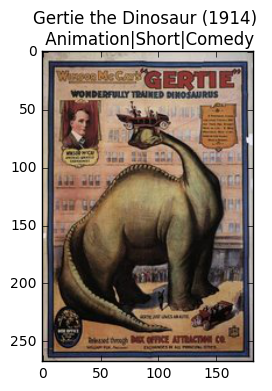

In [35]:
display_poster('4008')

### Scale the images equally

In [36]:
sample_img1 = get_image('10726')
sample_img1.shape

(268, 182, 3)

In [37]:
def preprocess(img, size=(150, 101)):
    
    img = scipy.misc.imresize(img, size)
    img = img.astype(np.float32)
    img = (img / 127.5) - 1
    
    return img

In [166]:
genre_per_movie = data['Genre'].apply(lambda x: str(x).split("|"))
print(genre_per_movie)

0             [Animation, Adventure, Comedy]
1                [Action, Adventure, Family]
2                          [Comedy, Romance]
3                   [Comedy, Drama, Romance]
4                  [Comedy, Family, Romance]
5                     [Action, Crime, Drama]
6                            [Comedy, Drama]
7                 [Adventure, Comedy, Drama]
8                  [Action, Crime, Thriller]
9              [Action, Adventure, Thriller]
10                  [Comedy, Drama, Romance]
11                 [Comedy, Fantasy, Horror]
12             [Animation, Adventure, Drama]
13               [Biography, Drama, History]
14               [Action, Adventure, Comedy]
15                            [Crime, Drama]
16                          [Drama, Romance]
17                                  [Comedy]
18                [Adventure, Comedy, Crime]
19                   [Action, Comedy, Crime]
20                 [Comedy, Crime, Thriller]
21                   [Crime, Drama, Mystery]
22        

In [136]:
def prepare_data(data, img_dict, size=(150, 101)):
    print("Generating dataset..")
    
    dataset = []
    
    y = []
    ids = []
    
    label_dict = {'word2idx': {}, 'idx2word': []}
    idx = 0
    
    genre_per_movie = data['Genre'].apply(lambda x: str(x).split("|"))
    
    for l in [g for d in genre_per_movie for g in d]:
        
        if l in label_dict['idx2word']:
            pass
        else:
            label_dict['idx2word'].append(l)
            label_dict['word2idx'][l] = idx
            idx += 1
        
    n_classes = len(label_dict['idx2word'])
    
        
    print("Identified {} classes".format(n_classes))
        
    n_samples = len(img_dict)
        
    print("Have {} samples".format(n_samples))
        
    for k in img_dict:
        
        #try:
        g = data[data['imdbId'] == int(k)]['Genre'].values[0].split("|")
            
        img = preprocess(img_dict[k], size)
            
        if img.shape != (150, 101, 3):
            continue
            
        l = np.sum([np.eye(n_classes, dtype='uint8')[label_dict['word2idx'][s]] for s in g], axis = 0)
            
        y.append(l)
        dataset.append(img)
        #print('Hey')
        ids.append(k)
            
        #except:
            
        
    print("DONE") 
    return dataset, y, label_dict, ids
    

In [137]:
SIZE = (150, 101)
dataset, y, label_dict, ids = prepare_data(data, img_dict, SIZE)

Generating dataset..
['Animation', 'Adventure', 'Comedy', 'Action', 'Family', 'Romance', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Horror', 'Biography', 'History', 'Mystery', 'Sci-Fi', 'War', 'Sport', 'Music', 'Documentary', 'Musical', 'Western', 'Short', 'Film-Noir', 'nan', 'Talk-Show', 'News', 'Adult', 'Reality-TV', 'Game-Show']
29
Identified 29 classes
Have 997 samples
997


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


DONE


In [158]:
model = Sequential()

class_weight = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0.6, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14:1 , 15:1 , 16:1 , 17:1 , 18:1 , 19:1 , 20:1, 21:1, 22:1, 23:1, 24:1, 25:1, 26:1, 27:1, 28:1}

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(SIZE[0], SIZE[1], 3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(29, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

n = 997
model.fit(np.array(dataset[:n]), np.array(y[:n]), batch_size = 16, class_weight=class_weight, epochs = 5, verbose = 1, validation_split = 100 // 997)

Epoch 1/5
997/997 [==============================] - 45s 45ms/step - loss: 0.5506 - acc: 0.9107
Epoch 2/5
997/997 [==============================] - 44s 44ms/step - loss: 0.3531 - acc: 0.9252
Epoch 3/5
997/997 [==============================] - 44s 44ms/step - loss: 0.3332 - acc: 0.9271
Epoch 4/5
997/997 [==============================] - 44s 44ms/step - loss: 0.3044 - acc: 0.9274
Epoch 5/5
997/997 [==============================] - 43s 44ms/step - loss: 0.2760 - acc: 0.9281


In [159]:
n_test = 100
X_test = dataset[0:100]
y_test = y[0:100]


In [160]:

D = np.array(X_test)
D.shape
pred= model.predict(D)

print(label_dict['idx2word'][1])
print(label_dict)
print(len(label_dict['idx2word']))
print(len(label_dict['word2idx']))


Adventure
{'idx2word': ['Animation', 'Adventure', 'Comedy', 'Action', 'Family', 'Romance', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Horror', 'Biography', 'History', 'Mystery', 'Sci-Fi', 'War', 'Sport', 'Music', 'Documentary', 'Musical', 'Western', 'Short', 'Film-Noir', 'nan', 'Talk-Show', 'News', 'Adult', 'Reality-TV', 'Game-Show'], 'word2idx': {'Sci-Fi': 14, 'Short': 21, 'nan': 23, 'Action': 3, 'Mystery': 13, 'Adventure': 1, 'Thriller': 8, 'Drama': 6, 'Crime': 7, 'Romance': 5, 'Musical': 19, 'Documentary': 18, 'Fantasy': 9, 'Adult': 26, 'Music': 17, 'War': 15, 'Film-Noir': 22, 'Western': 20, 'Comedy': 2, 'Animation': 0, 'History': 12, 'Reality-TV': 27, 'Biography': 11, 'News': 25, 'Sport': 16, 'Family': 4, 'Horror': 10, 'Game-Show': 28, 'Talk-Show': 24}}
29
29


In [161]:
def show_example(idx):
    N_true = int(np.sum(y_test[idx]))
    #print(len(ids))
    display_poster(ids[idx])
    
    print("Prediction: {}".format("|".join(["{} ({:.3})".format(label_dict["idx2word"][s],
                                                                pred[idx][s])
                                            for s in pred[idx].argsort()[-N_true:][::-1]])))

Prediction: Drama (0.43)|Comedy (0.319)|Romance (0.267)


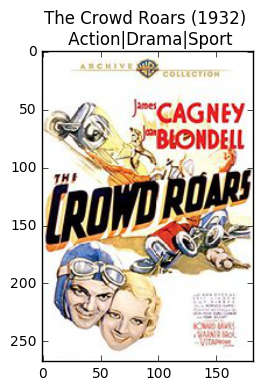

In [164]:
show_example(45)